# Imports

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from models.trained_models.unet_wavelet import UNetWavelet

from utils.image_helpers import load_images, plot_image_grid, show_images, rgb2gray, image_to_tensor, tensor_to_image
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from simulation.Simulation import Simulation
from utils.evaluation_helpers import calculate_full_width_half_maximum_value

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Configuration

In [2]:
input_size = (800, 800)
cropped_size = (100, 100)
snr = 10
pf_factor = 8

# Create Image & Simulate Gibbs

In [3]:
def create_diagonal_contrast(size):
    return np.triu(np.ones(shape=size))

def create_vertical_contrast(size, line_width=None):
    x, y = size
    left_half = np.ones((x,y//2))
    if line_width is not None:
        middle_index = left_half.shape[1]//2
        left_half[:,middle_index-line_width:middle_index+line_width] = 0
    right_half = np.zeros((x,y//2))
    return np.concatenate((left_half, right_half), axis=1)

In [4]:
diagonal_image = create_diagonal_contrast(input_size)
vertical_image = create_vertical_contrast(input_size, line_width=4)

In [5]:
simulation = Simulation(input_size=input_size, 
                        cropped_size=cropped_size, 
                        snr_range=(snr, snr), 
                        pf_factor=pf_factor)
diagonal_noisy_image, diagonal_target_image = simulation(diagonal_image)
vertical_noisy_image, vertical_target_image = simulation(vertical_image)

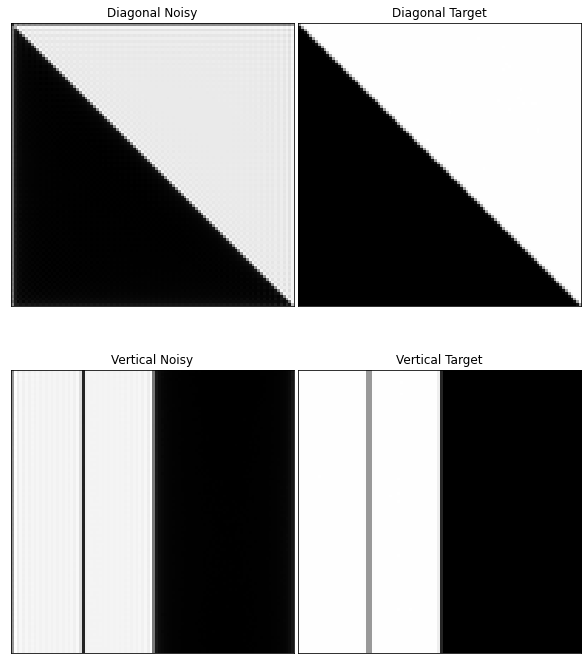

In [6]:
images = [diagonal_noisy_image, diagonal_target_image, vertical_noisy_image, vertical_target_image]
titles = ['Diagonal Noisy', 'Diagonal Target', 'Vertical Noisy', 'Vertical Target']
plot = plot_image_grid(images, titles, ncols=2)

# Fitting Deep Decoder

In [7]:
number_of_runs = 10

fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.model_type = 'deep'
fit_model_configuration.input_shape = [14, 14]
fit_model_configuration.number_of_hidden_channels = 40
fit_model_configuration.number_of_layers = 5
fit_model_configuration.log_frequency = 50
fit_model_configuration.convergence_check_length = None
fit_model_configuration.number_of_iterations = 3000
fit_model_configuration.image_dimensions = (100,100,1)
fit_model_configuration.find_best = True
fit_model_configuration.save_losses = False
print(fit_model_configuration)

image_dimensions: (100, 100, 1)  
result_path: data/results/  
model_type: deep  
input_shape: [14, 14]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 3000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 50  
find_best: True  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



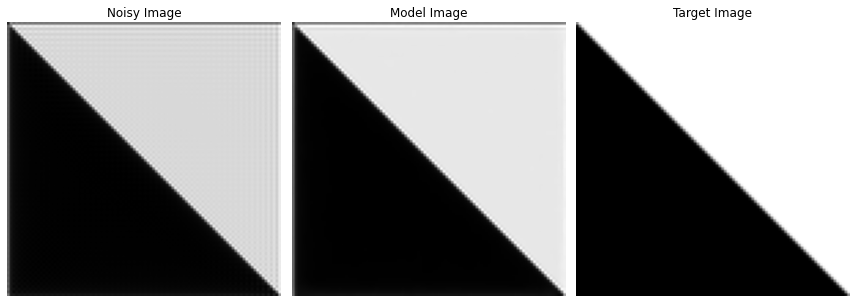

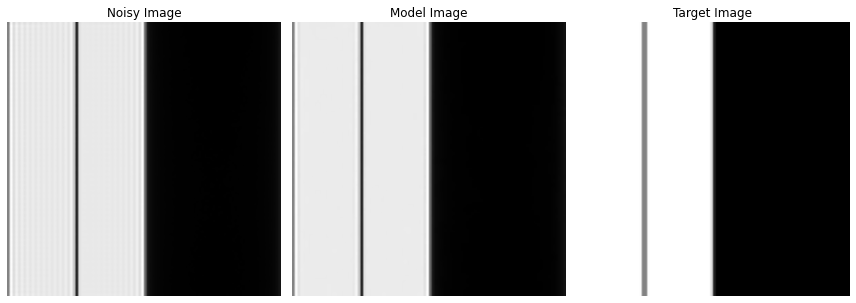

In [8]:
vertical_model_images = []
diagonal_model_images = []

fitter = create_fitter_from_configuration(fit_model_configuration)

for index in range(number_of_runs):
    model = create_model_from_configuration(fit_model_configuration)
    log_prefix = f'Run {2*index+1}/{number_of_runs*2}, '
    fitter(model, diagonal_noisy_image, log_prefix=log_prefix)
    diagonal_model_image = fitter.get_best_image()
    diagonal_model_images.append(diagonal_model_image)
    
    model = create_model_from_configuration(fit_model_configuration)
    log_prefix = f'Run {2*index+2}/{number_of_runs*2}, '
    fitter(model, vertical_noisy_image, log_prefix=log_prefix)
    vertical_model_image = fitter.get_best_image()
    vertical_model_images.append(vertical_model_image)
    
diagonal_model_image = np.mean(diagonal_model_images, axis=0)
show_images(diagonal_noisy_image, diagonal_model_image, diagonal_target_image)

vertical_model_image = np.mean(vertical_model_images, axis=0) 
show_images(vertical_noisy_image, vertical_model_image, vertical_target_image)

# Load & Apply Trained Model

In [9]:
path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False
#print(list(trained_model.parameters())[0].shape)
#summary(trained_model, (1, 100, 100), dtypes=[torch.cuda.FloatTensor], depth=3)

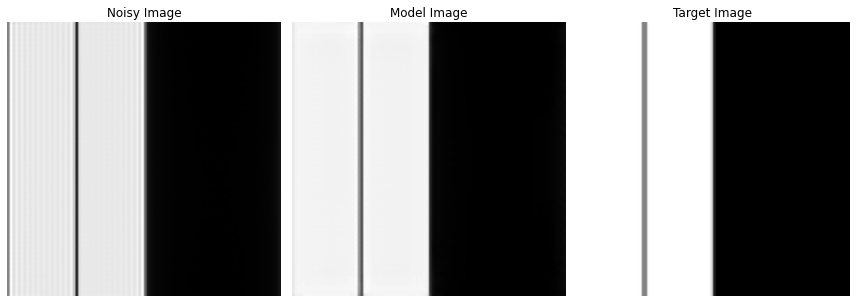

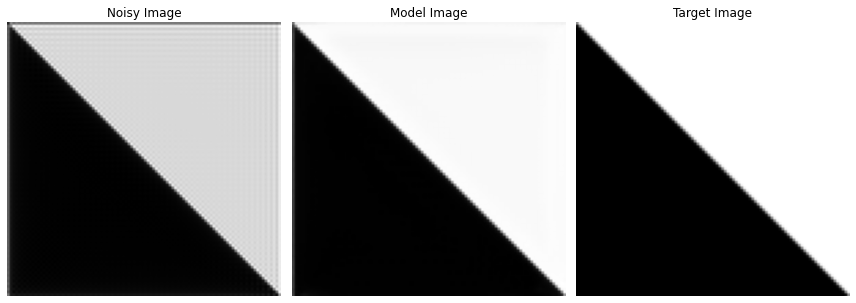

In [10]:
vertical_noisy_tensor = image_to_tensor(vertical_noisy_image).unsqueeze(0).type(dtype)
diagonal_noisy_tensor = image_to_tensor(diagonal_noisy_image).unsqueeze(0).type(dtype)
vertical_trained_tensor = trained_model(vertical_noisy_tensor)
diagonal_trained_tensor = trained_model(diagonal_noisy_tensor)
vertical_trained = tensor_to_image(vertical_trained_tensor.cpu().squeeze(0))
diagonal_trained = tensor_to_image(diagonal_trained_tensor.cpu().squeeze(0))

show_images(vertical_noisy_image, vertical_trained, vertical_target_image)
show_images(diagonal_noisy_image, diagonal_trained, diagonal_target_image)

# Plotting Results regarding edges

In [11]:
def calculate_diagonal_profile(image):
    diags = [image.diagonal(i) for i in range(image.shape[1]-1,-image.shape[0],-1)]
    return [np.mean(diag) for diag in diags]

def calculate_vertical_profile(image):
    columns = np.mean(image, axis=0)
    return columns

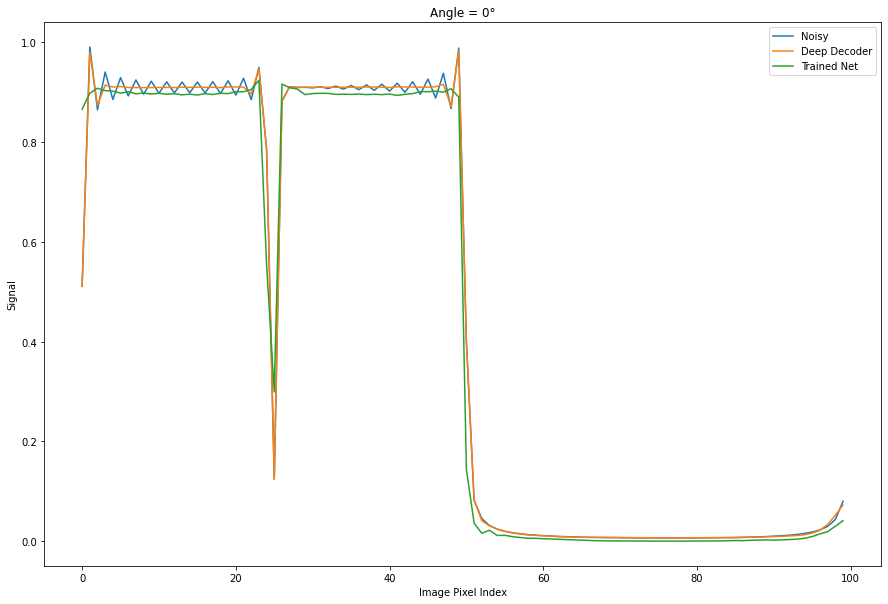

In [12]:
plt.figure(figsize=(15,10))
plt.plot(calculate_vertical_profile(vertical_noisy_image),label="Noisy")
plt.plot(calculate_vertical_profile(vertical_model_image),label="Deep Decoder")
plt.plot(calculate_vertical_profile(vertical_trained),label="Trained Net")
plt.title('Angle = 0°')
plt.xlabel('Image Pixel Index')
plt.ylabel('Signal')
plt.legend()
plt.show()

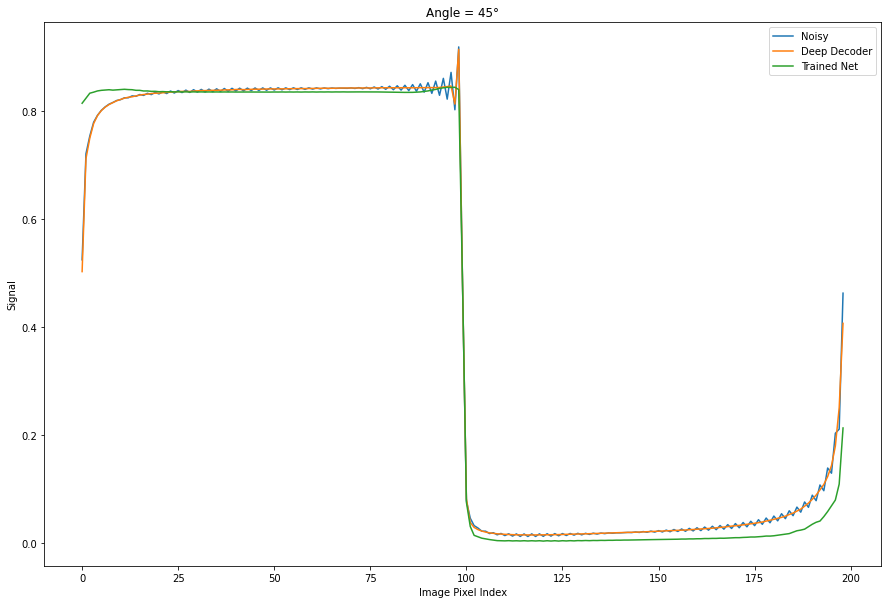

In [13]:
plt.figure(figsize=(15,10))
plt.plot(calculate_diagonal_profile(diagonal_noisy_image),label="Noisy")
plt.plot(calculate_diagonal_profile(diagonal_model_image),label="Deep Decoder")
plt.plot(calculate_diagonal_profile(diagonal_trained),label="Trained Net")
plt.title('Angle = 45°')
plt.xlabel('Image Pixel Index')
plt.ylabel('Signal')
plt.legend()
plt.show()